## 2D Geometric Transformations (Rotation, Scale and Translation)

In this example, we are going to register the faces of two Avengers and then use alpha blending to blend the images together.

## Change working directory (can also be changed from terminal if working locally)

Change working directory to directory containing the notebook and images (e.g. is using Google Colab)

In [207]:
# In terminal cce3207-venv

## Load images and data

Load the landmark points of the images using `pandas`

In [208]:
import pandas as pd

# Load the data

df = pd.read_csv('Data/landmarks.csv')

In [209]:
# Show the data
df

,Name,REx,REy,LEx,LEy,NCx,NCy,RMx,RMy,CMx,CMy,LMx,LMy
0,thor,1373,314,1430,316,1382,337,1366,380,1383,376,1409,379
1,hulk,377,150,426,150,401,172,377,198,400,198,422,196
2,captainamerica,413,102,463,102,448,131,426,160,445,160,459,159


Load and show the two original images

In [210]:
# Define path where images are saved
base_path = "Data"

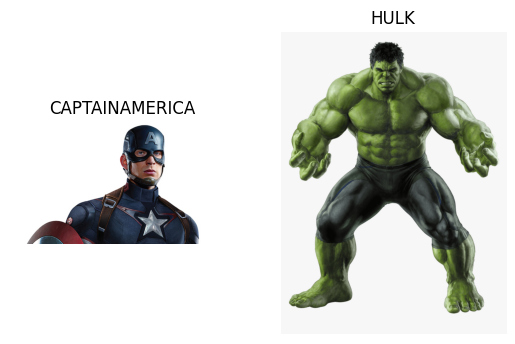

In [211]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import numpy as np

# Define the name of the avenger to consider
avenger1 = 'captainamerica'
avenger2 = 'hulk'

# Read png image files
im1 = img.imread(os.path.join(base_path, avenger1 + '.png'))
im2 = img.imread(os.path.join(base_path, avenger2 + '.png'))

# Show image
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.title(avenger1.upper())
plt.imshow(im1)

plt.subplot(1,2,2)
plt.axis('off')
plt.title(avenger2.upper())
plt.imshow(im2)

Overlay the feature points on the original image

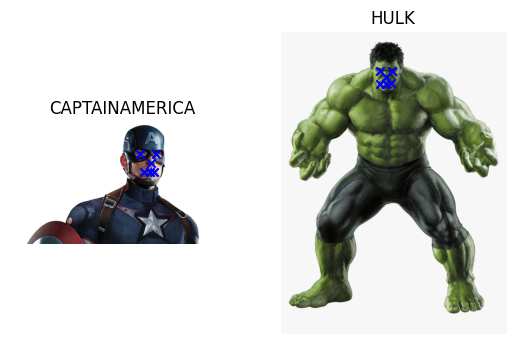

In [212]:
# This function reads the coordinates from the landmarks.csv file
def get_coordinates(df, avenger):

    # Derive coordinates of the particular avenger
    df_coord = df.loc[df['Name'] == avenger]

    # Put the data stored in csv into a numpy array
    coord = np.zeros((6,2))
    coord[0,0] = float(df_coord.iloc[0]['REx'])
    coord[0,1] = float(df_coord.iloc[0]['REy'])

    coord[1,0] = float(df_coord.iloc[0]['LEx'])
    coord[1,1] = float(df_coord.iloc[0]['LEy'])

    coord[2,0] = float(df_coord.iloc[0]['NCx'])
    coord[2,1] = float(df_coord.iloc[0]['NCy'])

    coord[3,0] = float(df_coord.iloc[0]['RMx'])
    coord[3,1] = float(df_coord.iloc[0]['RMy'])

    coord[4,0] = float(df_coord.iloc[0]['CMx'])
    coord[4,1] = float(df_coord.iloc[0]['CMy'])

    coord[5,0] = float(df_coord.iloc[0]['LMx'])
    coord[5,1] = float(df_coord.iloc[0]['LMy'])

    return coord

# Get the coordinates of the face images
coord1 = get_coordinates(df, avenger1)
coord2 = get_coordinates(df, avenger2)

# Show images
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1)
plt.title(avenger1.upper())
plt.axis('off')
plt.scatter(coord1[:,0], coord1[:,1], marker="x", color='blue')

plt.subplot(1,2,2)
plt.imshow(im2)
plt.title(avenger2.upper())
plt.axis('off')
plt.scatter(coord2[:,0], coord2[:,1], marker="x", color='blue')


## Compute the affine transformation matrices

Use least squares to estimate the affine transformations, and to warp and crop the images to get the frontal face.

In [213]:
# Estimate affine transformation using least squares
def affine_estimation(coord):

    # Reference coordinates (where the new landmarks should lie)
    b = [30, 98, 64, 48, 64, 80] # x-coordinates
    c = [30, 30, 64, 98, 98, 98] # y-coordinates

    # Construct the matrix A from the coordinates
    A = np.zeros((6,3))
    A[:, 0] = coord[:, 0]
    A[:, 1] = coord[:, 1]
    A[:, 2] = 1

    # Calculate the transpose of A
    At = np.transpose(A)

    # Calculate the value of x using the Least Squares method
    x = np.linalg.inv(np.dot(At, A)).dot(At).dot(b)

    # Calculate the value of y using the Least Squares method
    y = np.linalg.inv(np.dot(At, A)).dot(At).dot(c)

    # Construct the transformation matrix
    T = np.zeros((3,3))
    T[:, 0] = x
    T[:, 1] = y
    T[2,2] = 1

    print(T)

    return T

In [214]:
# Estimate the affine transformation using least squares
T1 = affine_estimation(coord1)
T2 = affine_estimation(coord2)

[[ 1.20790431e+00  9.40075218e-03  0.00000000e+00]
 [-1.00699275e-01  1.17847065e+00  0.00000000e+00]
 [-4.56634805e+02 -9.43707842e+01  1.00000000e+00]]
[[ 1.07930782e+00  2.91714154e-02  0.00000000e+00]
 [ 4.84545457e-02  1.43215535e+00  0.00000000e+00]
 [-3.76855388e+02 -1.95985368e+02  1.00000000e+00]]


In [215]:
# Compute the warping process
def warping(im, T):
    # [v, w, 1] = [x, y, 1] * T
    # Compute the inverse affine matrix
    Tinv = np.linalg.inv(T)

    n_rows = 128
    n_cols = 128

    im2 = np.zeros((n_rows, n_cols, 4))

    # Inverse mapping: 
    # [x, y, 1] = [v, w, 1] * Tinv
    for v in range(n_rows):
        for w  in range(n_cols):
            # Derive the pixel coordinates to take from the reference image
            # USe the inverse of affine transformation to find the pixel coordinates
            x ,y ,_ = np.dot([v, w, 1], Tinv) 

            # Round the pixel coordinates
            x = np.round(x).astype(int)
            y = np.round(y).astype(int)

            im2 [w, v, :] = im[y, x, :]
            
    return im2

In [216]:
# Warp the images
I1 = warping(im1, T1)
I2 = warping(im2, T2)


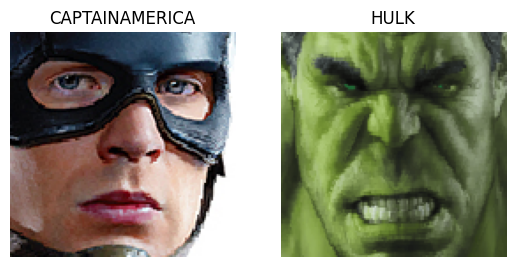

In [217]:
# Show the images
plt.figure()
plt.subplot(1,2,1)
plt.title(avenger1.upper())
plt.axis('off')
plt.imshow(I1)

plt.subplot(1,2,2)
plt.title(avenger2.upper())
plt.axis('off')
plt.imshow(I2)


## Blend the two images

We then use alpha blending of the two images

In [218]:
import imageio
from IPython.display import Video;

# Define range of alphas
alphas = np.arange( 0, 1.1, 0.1)

# Perform the blending
vid = np.zeros((len(alphas), I1.shape[0], I1.shape[1], I1.shape[2]))
for i, alpha in enumerate(alphas):
    # Linear blending of the images to create the video
    vid[i,:,:,:] = alpha*I1 + (1-alpha)*I2


In [219]:
# Define video path
video_path = 'blending.mp4'

In [220]:
# Save the video using imageio with FFMPEG format
with imageio.get_writer(video_path, format='FFMPEG', fps=30) as writer:
    for i in range(vid.shape[0]):
        writer.append_data((vid[i]*255).astype(np.uint8))

In [221]:
# Display the video in the notebook using the width and height of the images
Video(video_path, width=vid.shape[2], height=vid.shape[1])